# Setting

In [1]:
import numpy as np
import pymc3 as pm
import os, math
import arviz as az

from scipy.special import comb
from statsmodels.stats.proportion import proportion_confint
from matplotlib import pyplot as plt

%load_ext autotime

time: 764 µs (started: 2023-04-26 22:07:07 +09:00)


In [2]:
def print_machine_type(thold_cpu=None, thold_mem=None):
    """ system info """
    cpu_count = os.cpu_count()
    tot_m, used_m, free_m = map(int, os.popen('free -t -m').readlines()[-1].split()[1:])
    mem_gb = round(tot_m/1024)
    print(f'{cpu_count} vCPUs, {mem_gb} GB RAM')
    for name, val, thold in [['cpu', cpu_count, thold_cpu],['mem', mem_gb, thold_mem]]:
        if thold is not None:
            if val < thold:
                print(f'{name} {val} less than the threshold {thold}')
    return (cpu_count, mem_gb)

time: 2.2 ms (started: 2023-04-26 22:07:07 +09:00)


In [3]:
def print_interval(low, high, text='confidence interval: '):
    #low, high = low*100, high*100
    p = (low+high)/2
    err = high - p
    #print(f'{text}{p:.3f} ± {err:.4f}, [{low:.3f}, {high:.3f}]')
    print(f'{text}{p} ± {err}, [{low}, {high}]')

time: 6.39 ms (started: 2023-04-26 22:07:07 +09:00)


# Qs

- 지난 4일 추첨이 된 1057회 로또 당첨 번호는 '8, 13, 19, 27, 40, 45'였고 2등 보너스 번호는 '12'였다. 
- 당첨 번호 5개와 보너스 번호가 일치한 2등은 전국에서 664장이 나왔다. 2등 당첨 664장 중 103장이 서울 동대문구 왕산로 복권 판매점에서 동시에 나온 것으로 알려져
- 해당 판매점에서 당첨된 2등 103장 중 '자동'은 1장, '수동'은 102장이었으며 '수동' 102장 중 100장은 같은 날짜, 같은 시간대에 판매돼 같은 사람이 구매한 것으로 추정
- 복권위는 "2등 당첨 확률은 136만분의 1로서 1057회차 판매량이 1억1252만장이었던 것을 고려하면 구매자가 균등하게 번호 조합을 선택할 경우 당첨자는 83명 내외 발생한다"고 설명.
- "하지만 현실에서는 구매자 선호 번호, 기존 회차 당첨 번호, 가로·세로·대각선과 같은 구매 용지 번호 배열 패턴 등 구매자 선택에 따라 이번 회차처럼 당첨자가 많을 수도 있고 극단적으로 1명까지 적어질 가능성도 존재"

## Q1. 2등 당첨 확률

- 로또 6/45의 2등 당첨 확률은 이상적인 경우(45개 모든 숫자의 추첨 확률은 동일하고, 구매자들이 균등하게 번호 조합을 선택할 경우) 136만분의 1
- 이상적인 경우 2등은 99% 신뢰수준에서 60에서 106장 사이
- 실제로는 2등 664장으로 당첨 확률은 17만분의 1로 크게 증가. 
- 그러나 적어도 100장은 동일한 사람이 구매한 것으로 추정되므로 구매자들의 균등한 번호 조합을 가정할 수 없는 상황.

In [6]:
N = 45
n = 6
k = 5

p2 = comb(n, k) * comb(n-k,1) * comb(N-n-1, 0) / comb(N,n)

print(f'2등 당첨 확률: {1/p2:,.0f}분의 1')
p2

2등 당첨 확률: 1,357,510분의 1


7.3664282399393e-07

time: 25.2 ms (started: 2023-04-25 13:14:31 +09:00)


In [7]:
n_game = 112520000

print(f'판매량 {n_game:,}장일 때 당첨자는 {p2 * n_game:.0f}명 내외 발생')

판매량 112,520,000장일 때 당첨자는 83명 내외 발생
time: 11.6 ms (started: 2023-04-25 13:14:32 +09:00)


In [11]:
n = n_game
k = 83

level = 0.99
alpha = 1 - level
method = 'normal'
low_high = proportion_confint(k, n, alpha, method=method)
x = [round(x*n) for x in low_high] 
print(f'{level*100:.0f}% 신뢰수준에서 당첨자수는 {x[0]}~{x[1]}명')

99% 신뢰수준에서 당첨자수는 60~106명
time: 16.7 ms (started: 2023-04-25 13:14:56 +09:00)


In [12]:
low_high

(5.290889341801798e-07, 9.462043470142746e-07)

time: 13.2 ms (started: 2023-04-25 13:14:58 +09:00)


2등 664장이 나왔을때 2등 당첨 확률

In [9]:
obs = 664
p = obs/n_game
print(f'2등 당첨 확률: {1/p:,.0f}분의 1')

2등 당첨 확률: 169,458분의 1
time: 6.24 ms (started: 2023-04-25 13:14:35 +09:00)


## Q2. 가정/시뮬레이션
만약 2등 당첨 664장이 균등한 조합의 결과였다면 로또 45개 숫자의 추첨 확률의 동일성을 의심할수 있을까?

- 구매자들이 균등하게 번호 조합을 선택한 결과 2등 당첨이 664장이라면 이상적인 당첨 확률은 실제 당첨 확률의 99% 범위 밖이라 할 수 있다.
- 그러나 그렇다고 개별 숫자의 당첨 확률이 오차 고려시 1/45가 아니라고 할 수는 없다.

### Q21. 2등 당첨 확률의 신뢰구간

In [50]:
mu = p_ref = p2
obs = 664
draws = n_game
sigma = mu*1000

# 1 < sigma < sqrt(mu * (1 - mu))
sigma_max = np.sqrt(mu * (1 - mu)) # max of sigma
if sigma > sigma_max:
    print(f'WARNING: sigma ({sigma}) is gt max ({sigma_max})')

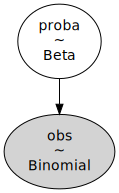

In [53]:
with pm.Model() as model:
    p = pm.Beta('proba', mu=mu, sigma=sigma)
    obs = pm.Binomial('obs', n=draws, p=p, observed=obs)
    
pm.model_to_graphviz(model=model)

In [57]:
n_tune, n_draws, n_chains = 5000, 10000, None
n_cpus, _ = print_machine_type()

with model:    
    trace = pm.sample(tune=n_tune, draws=n_draws, cores=n_cpus, chains=n_chains,
                      target_accept=0.95,
                      return_inferencedata=True)

2 vCPUs, 5 GB RAM


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [proba]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 65 seconds.


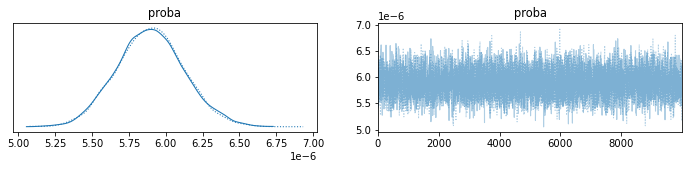

time: 1.04 s (started: 2023-04-24 21:03:40 +09:00)


In [61]:
_ = az.plot_trace(trace)

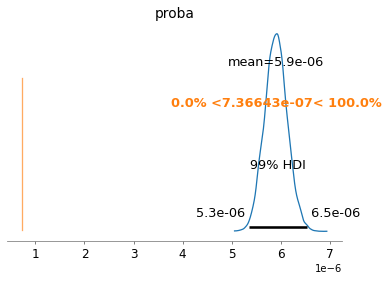

time: 494 ms (started: 2023-04-24 22:21:16 +09:00)


In [83]:
 _ = az.plot_posterior(trace, ref_val=p_ref, hdi_prob=.99, textsize=12)

### Q22. 각 숫자의 추첨 확률
구매자들이 균등하게 번호 조합을 선택한 결과 2등 당첨이 664장이라면 각 추첨 번호의 확률은 1/45가 아니라고 의심할 수 있을까?

In [92]:
mu = p_ref = 1/N
obs = 664
draws = n_game
sigma = mu*1

n = 6
k = 5

time: 1.38 ms (started: 2023-04-24 22:31:01 +09:00)


In [89]:
# 예제: 각 숫자의 추첨 확률을 개별적으로 가정할 2등 당첨 확률의 계산 방법
p_k = [1/N]*n # 2등 당첨 숫자의 확률 개별적으로 (동일하게) 부여

ite = [i*x/(1-x*(i-1)) for i, x in enumerate(p_k,1)]
p2 = comb(n, k) * math.prod(ite)
p2

7.3664282399393e-07

time: 11.8 ms (started: 2023-04-24 22:28:52 +09:00)


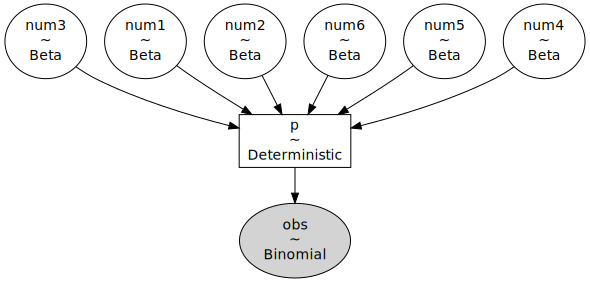

time: 5.86 s (started: 2023-04-24 22:31:17 +09:00)


In [94]:
p_n = [mu]*n
p_num = [None]*n

with pm.Model() as model:
    for i in range(n):
        # 2등 당첨 숫자 5개와 보너스 1개의 사전 추첨 확률을 베타분포로 개별적으로 가정.
        p_num[i] = pm.Beta(f'num{i+1}', mu=p_n[i], sigma=sigma)
    
    # 개별 숫자들의 추첨 확률로 2등 추첨 확률을 계산
    p = [i*x/(1-x*(i-1)) for i, x in enumerate(p_num,1)]
    p = pm.Deterministic('p', comb(n, k) * pm.math.prod(p))
    
    # 사후 확률
    obs = pm.Binomial('obs', n=draws, p=p, observed=obs)
    
pm.model_to_graphviz(model=model)

In [95]:
#n_tune, n_draws, n_chains = 2000, 1000, None
n_tune, n_draws, n_chains = 5000, 10000, None # 시간은 엄청 오래 걸리는데 대세 변함 없음.
n_cpus, _ = print_machine_type()

with model:    
    trace = pm.sample(tune=n_tune, draws=n_draws, cores=n_cpus, chains=n_chains,
                      target_accept=0.95,
                      return_inferencedata=True)

2 vCPUs, 5 GB RAM


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [num6, num5, num4, num3, num2, num1]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 2379 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.


time: 40min 18s (started: 2023-04-24 22:33:34 +09:00)


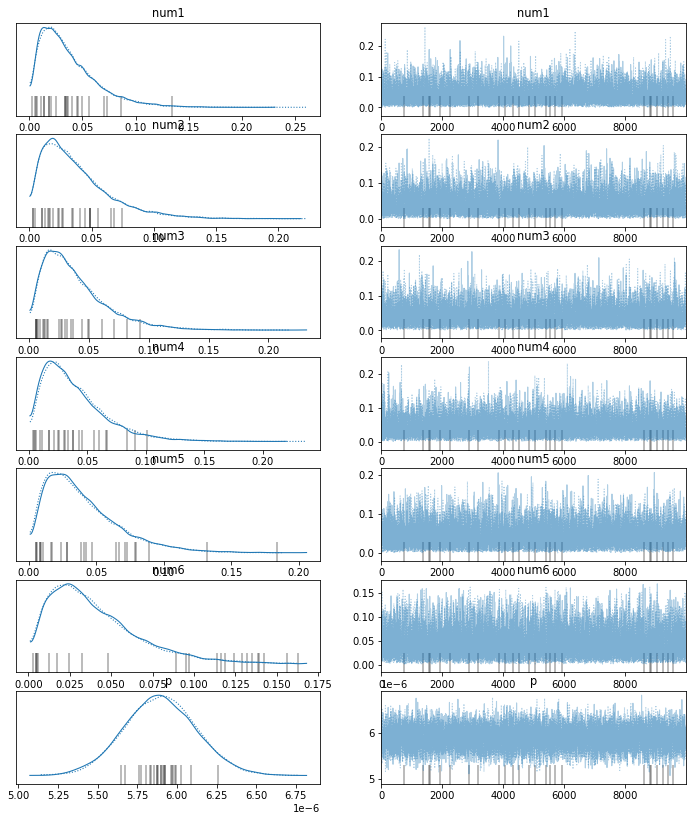

time: 4.79 s (started: 2023-04-24 23:13:52 +09:00)


In [96]:
_ = az.plot_trace(trace)

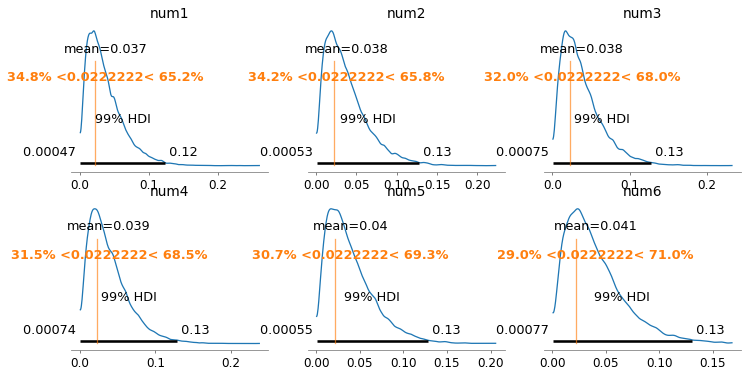

time: 1.5 s (started: 2023-04-24 23:15:29 +09:00)


In [99]:
fig, ax = plt.subplots(2,3, figsize=(12,6))

nums_to_plot = range(n)
#nums_to_plot = np.sort(np.random.choice(n, 2, replace=False))

_ = az.plot_posterior(trace, ref_val=p_ref, var_names=[f'num{i+1}' for i in nums_to_plot], 
                      textsize=12,
                      hdi_prob=.99, ax=ax)

# testing

In [4]:
N = 45
n = 6
k = 5

p2 = comb(n, k) * comb(n-k,1) * comb(N-n-1, 0) / comb(N,n)

print(f'2등 당첨 확률: {1/p2:,.0f}분의 1')
p2

2등 당첨 확률: 1,357,510분의 1


7.3664282399393e-07

time: 26.8 ms (started: 2023-04-25 14:36:50 +09:00)


In [5]:
n_game = 112520000

print(f'판매량 {n_game:,}장일 때 당첨자는 {p2 * n_game:.0f}명 내외 발생')

판매량 112,520,000장일 때 당첨자는 83명 내외 발생
time: 3.52 ms (started: 2023-04-25 14:36:50 +09:00)


In [6]:
# proba of number
mu = p_ref = p2
obs = 664
draws = n_game
sigma = mu*100

mu2 = obs / n_game 
sigma2 = mu2*100

time: 7.2 ms (started: 2023-04-25 14:36:50 +09:00)


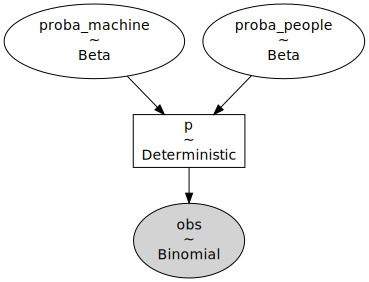

time: 10.1 s (started: 2023-04-25 14:36:51 +09:00)


In [7]:
with pm.Model() as model:
    p1 = pm.Beta('proba_machine', mu=mu, sigma=sigma)
    p2 = pm.Beta('proba_people', mu=mu2, sigma=sigma2)
    p = pm.Deterministic('p', p1 * p1 / p2)
    p_obs = pm.Binomial('obs', n=draws, p=p, observed=obs)
    
pm.model_to_graphviz(model=model)

In [8]:
n_tune, n_draws, n_chains = 1000, 1000, None
n_cpus, _ = print_machine_type()

with model:    
    trace = pm.sample(tune=n_tune, draws=n_draws, cores=n_cpus, chains=n_chains,
                      target_accept=0.95,
                      return_inferencedata=True)

2 vCPUs, 5 GB RAM


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [proba_people, proba_machine]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 474 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9007471339545875, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


time: 8min 18s (started: 2023-04-25 14:37:01 +09:00)


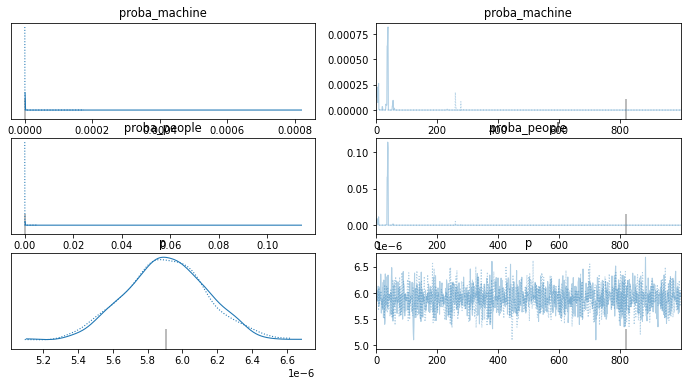

time: 2.27 s (started: 2023-04-25 14:45:19 +09:00)


In [9]:
_ = az.plot_trace(trace)

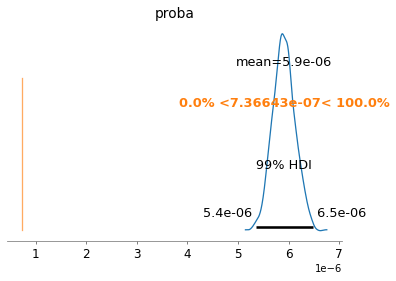

time: 375 ms (started: 2023-04-25 13:18:42 +09:00)


In [19]:
 _ = az.plot_posterior(trace, ref_val=p_ref, hdi_prob=.99, textsize=12)

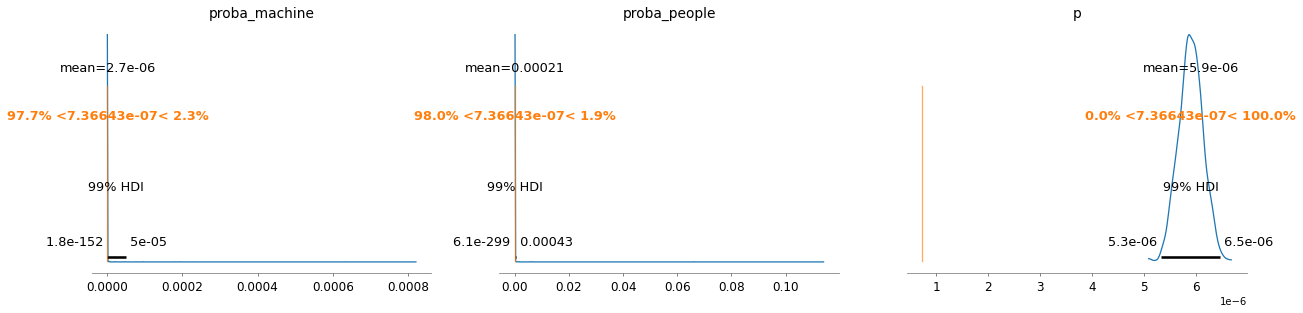

time: 926 ms (started: 2023-04-25 14:45:21 +09:00)


In [10]:
 _ = az.plot_posterior(trace, ref_val=p_ref, hdi_prob=.99, textsize=12)

In [11]:
obs/n_game

5.9011731247778175e-06

time: 14.7 ms (started: 2023-04-25 14:45:55 +09:00)


# testing

- 1057회차 판매량이 1억1252만장
- 2등 103장 중 '자동'은 1장, '수동'은 102장이었으며 '수동' 102장 중 100장은 같은 날짜, 같은 시간대에 판매돼 같은 사람이 구매한 것으로 추정
- 8, 13, 19, 27, 40, 45 + 12

In [4]:
n_game = 112520000
ns = [17, 664, 2962, 146471, 2461496]

time: 864 µs (started: 2023-04-26 12:24:50 +09:00)


In [6]:
sum(ns)/n_game

0.023210184856025596

time: 8.82 ms (started: 2023-04-26 12:25:00 +09:00)


In [7]:
N = 45
n = 6
n_game / comb(N, n)

13.814508425966169

time: 11.3 ms (started: 2023-04-26 12:26:51 +09:00)


In [13]:
n_comb = dict()
n_comb[(8,13,19,27,40,45)] = 17
n_comb

{(8, 13, 19, 27, 40, 45): 17}

time: 12.5 ms (started: 2023-04-26 12:35:41 +09:00)


In [14]:
x = 664/comb(6,5)
n_comb[(12,13,19,27,40,45)] = x
n_comb[(8,12,19,27,40,45)] = x
n_comb[(8,13,12,27,40,45)] = x
n_comb[(8,13,19,12,40,45)] = x
n_comb[(8,13,19,27,12,45)] = x
n_comb[(8,13,19,27,40,12)] = x
n_comb

{(8, 13, 19, 27, 40, 45): 17,
 (12, 13, 19, 27, 40, 45): 110.66666666666667,
 (8, 12, 19, 27, 40, 45): 110.66666666666667,
 (8, 13, 12, 27, 40, 45): 110.66666666666667,
 (8, 13, 19, 12, 40, 45): 110.66666666666667,
 (8, 13, 19, 27, 12, 45): 110.66666666666667,
 (8, 13, 19, 27, 40, 12): 110.66666666666667}

time: 26.1 ms (started: 2023-04-26 12:37:31 +09:00)


In [21]:
x = 2962/(comb(6,5)*comb(45-6-1,1))/43
n_comb[(0,13,19,27,40,45)] = x
n_comb[(8,0,19,27,40,45)] = x
n_comb[(8,13,0,27,40,45)] = x
n_comb[(8,13,19,0,40,45)] = x
n_comb[(8,13,19,27,0,45)] = x
n_comb[(8,13,19,27,40,0)] = x
n_comb

{(8, 13, 19, 27, 40, 45): 17,
 (12, 13, 19, 27, 40, 45): 110.66666666666667,
 (8, 12, 19, 27, 40, 45): 110.66666666666667,
 (8, 13, 12, 27, 40, 45): 110.66666666666667,
 (8, 13, 19, 12, 40, 45): 110.66666666666667,
 (8, 13, 19, 27, 12, 45): 110.66666666666667,
 (8, 13, 19, 27, 40, 12): 110.66666666666667,
 (0, 13, 19, 27, 40, 45): 0.30212158302733577,
 (8, 0, 19, 27, 40, 45): 0.30212158302733577,
 (8, 13, 0, 27, 40, 45): 0.30212158302733577,
 (8, 13, 19, 0, 40, 45): 0.30212158302733577,
 (8, 13, 19, 27, 0, 45): 0.30212158302733577,
 (8, 13, 19, 27, 40, 0): 0.30212158302733577}

time: 18.5 ms (started: 2023-04-26 12:46:01 +09:00)


In [10]:
x = 146471/comb(6,4)
n_comb[(0,0,19,27,40,45)] = x
n_comb[(8,0,0,27,40,45)] = x
n_comb[(8,13,0,27,40,45)] = x
n_comb[(8,13,19,0,40,45)] = x
n_comb[(8,13,19,27,0,45)] = x
n_comb[(8,13,19,27,40,0)] = x
n_comb

[17, 17, 17, 17, 17, 17, 0]

time: 14.5 ms (started: 2023-04-26 12:30:56 +09:00)


# testing

- 1057회차 판매량이 1억1252만장
- 2등 103장 중 '자동'은 1장, '수동'은 102장이었으며 '수동' 102장 중 100장은 같은 날짜, 같은 시간대에 판매돼 같은 사람이 구매한 것으로 추정
- 8, 13, 19, 27, 40, 45 + 12

In [23]:
n_game = 112520000
ns = [17, 664, 2962, 146471, 2461496]

time: 928 µs (started: 2023-04-26 12:48:46 +09:00)


In [37]:
N = 45
n = 6
comb(N, n) * n / N

1086008.0

time: 14.2 ms (started: 2023-04-26 13:19:07 +09:00)


In [38]:
n_game * n / N

15002666.666666666

time: 7.41 ms (started: 2023-04-26 13:19:43 +09:00)


In [32]:
nums = dict(zip(range(1,46),[0]*45))

x = {k:nums[k]+17 for k in [8, 13, 19, 27, 40, 45]}
nums.update(x)

x = {k:nums[k]+5 for k in [8, 13, 19, 27, 40, 45]}
nums.update(x)

x = {k:nums[k]+6 for k in [12]}
nums.update(x)

time: 7.41 ms (started: 2023-04-26 12:55:06 +09:00)


In [39]:
6/comb(N,n)*n_game

82.887050555797

time: 5.89 ms (started: 2023-04-26 13:57:01 +09:00)


In [40]:
import scipy.stats as stats

dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = stats.bernoulli.rvs(0.5, size=n_trials[-1])
data

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,

time: 33.5 ms (started: 2023-04-26 14:50:44 +09:00)


# testing

- 1057회차 판매량이 1억1252만장
- 2등 103장 중 '자동'은 1장, '수동'은 102장이었으며 '수동' 102장 중 100장은 같은 날짜, 같은 시간대에 판매돼 같은 사람이 구매한 것으로 추정
- 8, 13, 19, 27, 40, 45 + 12

In [44]:
from scipy.stats import poisson

In [47]:
N = 45
n = 6
n_game = 112520000

mu = n_game / comb(N, n)
mu

13.814508425966169

time: 17.6 ms (started: 2023-04-26 15:24:13 +09:00)


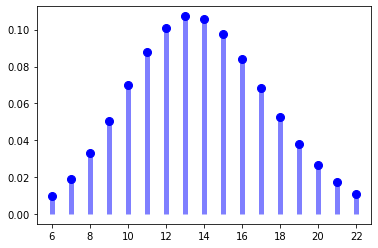

time: 415 ms (started: 2023-04-26 15:24:14 +09:00)


In [48]:
fig, ax = plt.subplots(1, 1)
x = np.arange(poisson.ppf(0.01, mu),
              poisson.ppf(0.99, mu))
ax.plot(x, poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
ax.vlines(x, 0, poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)

In [80]:
N = 45
n = 6
n_game = 112520000

ns = [17, 664, 2962, 146471, 2461496]

k = ns[0]
#k = ns[1] / 6

time: 1.25 ms (started: 2023-04-26 17:01:11 +09:00)


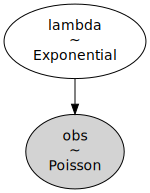

time: 561 ms (started: 2023-04-26 17:01:12 +09:00)


In [81]:
alpha = comb(N, n) / n_game # inverse of mean of number of combination

with pm.Model() as model:
    lamb = pm.Exponential("lambda", alpha)
    obs = pm.Poisson("obs", mu=lamb, observed=k)
    
pm.model_to_graphviz(model=model)

In [82]:
n_tune, n_draws, n_chains = 1000, 1000, None
n_cpus, _ = print_machine_type()

with model:    
    trace = pm.sample(tune=n_tune, draws=n_draws, cores=n_cpus, chains=n_chains,
                      target_accept=0.95,
                      return_inferencedata=True)

2 vCPUs, 5 GB RAM


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


time: 10.5 s (started: 2023-04-26 17:01:12 +09:00)


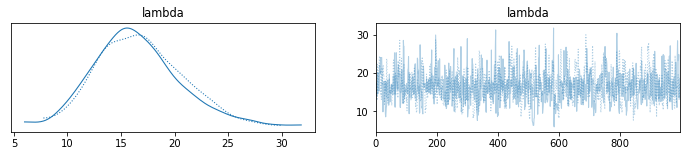

time: 562 ms (started: 2023-04-26 17:01:23 +09:00)


In [83]:
_ = az.plot_trace(trace)

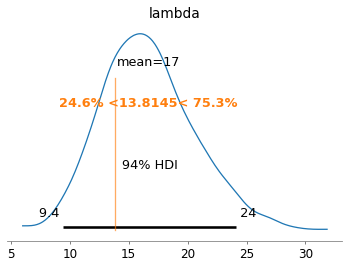

time: 306 ms (started: 2023-04-26 17:01:24 +09:00)


In [85]:
# 1등 숫자조합
_ = az.plot_posterior(trace, 
                       ref_val=1/alpha, 
                       #hdi_prob=.99, 
                       textsize=12)

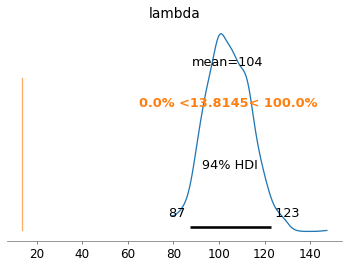

time: 338 ms (started: 2023-04-26 17:00:49 +09:00)


In [79]:
# 2등 숫자조합
_ = az.plot_posterior(trace, 
                       ref_val=1/alpha, 
                       #hdi_prob=.99, 
                       textsize=12)

In [65]:
conf = 0.94
poisson.inverval(conf, c2)

AttributeError: 'poisson_gen' object has no attribute 'inverval'

time: 37.4 ms (started: 2023-04-26 16:55:57 +09:00)


In [74]:
1/alpha, k

(13.814508425966167, 110.66666666666667)

time: 3.8 ms (started: 2023-04-26 16:59:25 +09:00)


In [72]:
poisson.ppf(0.03, 1/alpha), poisson.ppf(1-0.03, 1/alpha)

(7.0, 21.0)

time: 18.1 ms (started: 2023-04-26 16:58:42 +09:00)


In [86]:
poisson.ppf(0.03, k), poisson.ppf(1-0.03, k)

(10.0, 25.0)

time: 15.7 ms (started: 2023-04-26 17:02:07 +09:00)


In [72]:
poisson.ppf(0.03, 1/alpha), poisson.ppf(1-0.03, 1/alpha)

(7.0, 21.0)

time: 18.1 ms (started: 2023-04-26 16:58:42 +09:00)


In [73]:
poisson.ppf(0.03, c2), poisson.ppf(1-0.03, c2)

(91.0, 131.0)

time: 18.4 ms (started: 2023-04-26 16:59:04 +09:00)


In [4]:
comb(45,6)

8145060.0

time: 15.7 ms (started: 2023-04-26 22:07:09 +09:00)
